In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
from scipy.stats import norm
from scipy.special import expit

In [3]:
# Reward component that penalizes velocities that are close to 0
def r_moving_function(v):
    k = 10 # How quickly the reward will decrease to 0 once we are approaching 0 velocity.
    v_0 = 1 # The speed below which we consider ourselves moving too slowly. "Stopped".
    return expit(k * (v - v_0))

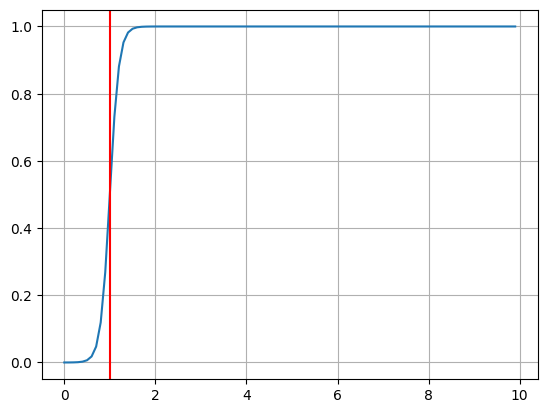

In [4]:
vs = np.arange(0.0, 10.0, 0.1)
plt.plot(vs, list(map(r_moving_function, vs)))
plt.axvline(x=1, color="r")
plt.grid()

In [5]:
# Reward component to penalize headways that are too small. This is a modified
# sigmoid function that will return ~0 at dist <= 0, and ~1 at dist >= dist_min,
# regardless of the value of dist_min. As such, it will have a shallower slope
# for larger dist_min and a narrower slow for smaller dist_min.
def r_penalize_too_close_function(dist, dist_min):
    return expit(6 * (2 * dist / dist_min - 1))

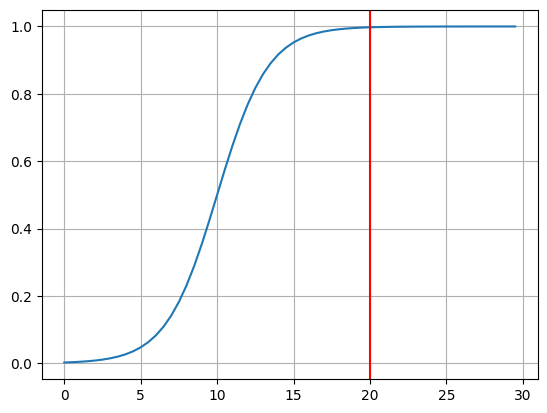

In [6]:
# Graphs demonstrating reward behavior for different dist_min
dists = np.arange(0.0, 30.0, 0.5)
dist_min = 20
plt.plot(dists, [r_penalize_too_close_function(d, dist_min) for d in dists])
plt.axvline(x=dist_min, color="r")
plt.grid()

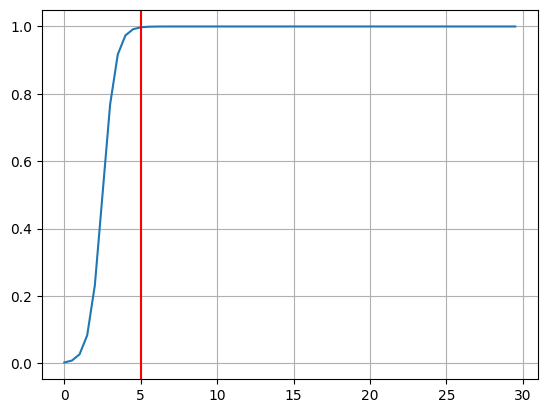

In [7]:
dist_min = 5
plt.plot(dists, [r_penalize_too_close_function(d, dist_min) for d in dists])
plt.axvline(x=dist_min, color="r")
plt.grid()

In [8]:
# Reward component that rewards velocities that are cose to the target velocity and nothing else
def r_target_function(v, v_t, spread):
    D = norm(loc=v_t, scale=spread)
    return D.pdf(v)

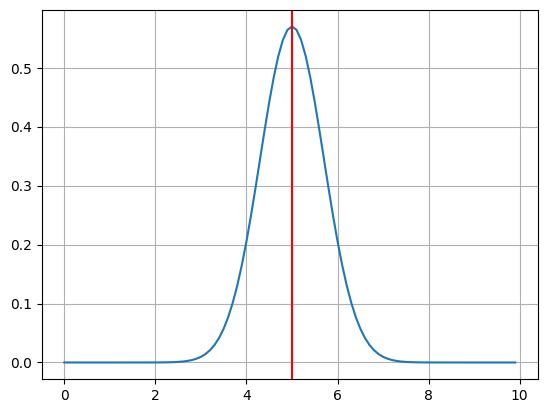

In [9]:
plt.plot(vs, [r_target_function(v, 5, 0.7) for v in vs])
plt.axvline(x=5, color="r")
plt.grid()

In [10]:
def reward(vels, dists_to_leader, dists_to_follower, min_dist_to_leader, min_dist_to_follower):
    target_vel = 20
    r_target_spread = 3

    # Calculate r_moving from the lowest velocity. If any vehicle is stopped, we
    # want the reward to be 0.
    r_is_moving = r_moving_function(vels.min())

    # For r_target_vel, we calculate the reward across all velocities and take the
    # sum, then normalize it against the maximum possible r_target_vel score, which
    # would be if every vehicle was traveling at exactly the target speed
    r_target_vel = r_target_function(vels, target_vel, r_target_spread).sum()
    max_r_target = r_target_function(target_vel, target_vel, r_target_spread) * len(vels)
    r_target_vel /= max_r_target

    r_penalize_too_close_to_leader = r_penalize_too_close_function(dists_to_leader, min_dist_to_leader).mean()
    r_penalize_too_close_to_follower = r_penalize_too_close_function(dists_to_follower, min_dist_to_follower).mean()

    return 10.0 * r_is_moving * r_penalize_too_close_to_leader * r_penalize_too_close_to_follower * r_target_vel

In [11]:
rand = np.random.default_rng()
N = 100 # How many vehicles
samples = 150 # How many "timesteps" to generate results for

In [12]:
vvs = np.array([rand.normal(loc=x, scale=0.5, size=N) for x in np.linspace(10, 30, num=samples)])

In [13]:
# So what I really want to do here is create a normal distribution of the
# headways that has its mean gradually migrating upwards with each experiment.
# Then for each experiment I can compute the total reward and we can see what happens.

min_dist = 20

dists = np.array([rand.normal(loc=x, scale=0.5, size=N) for x in np.linspace(5, 30, num=samples)])

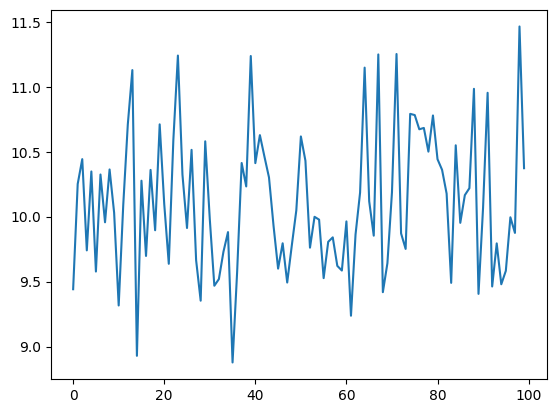

In [14]:
plt.plot(np.arange(N), vvs[0])

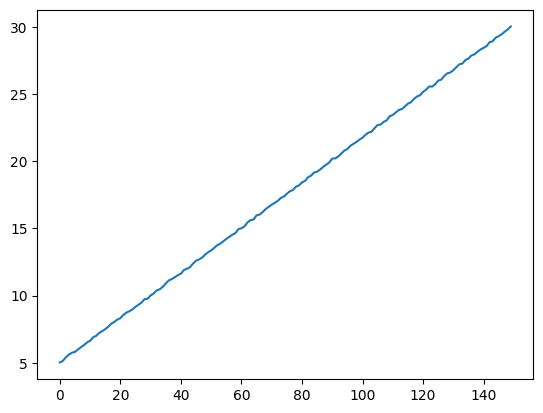

In [15]:
plt.plot(np.arange(samples), np.mean(dists, axis=1))

In [16]:
X = np.mean(vvs, axis=1)
Y = np.mean(dists, axis=1)
Z = np.array([[reward(vv, dist, dist, min_dist, min_dist) for vv in vvs] for dist in dists])

In [17]:
X, Y = np.meshgrid(X, Y)

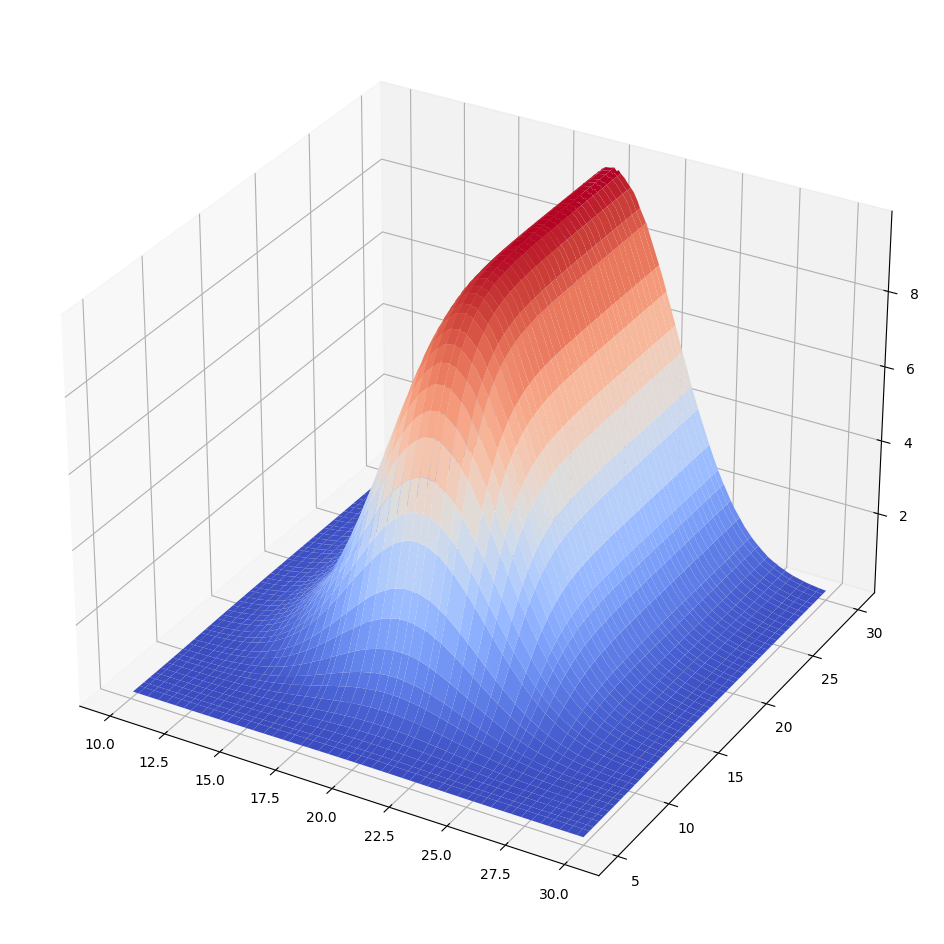

In [18]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.set_figwidth(12)
fig.set_figheight(12)
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)